# MGFD25 In-class Coding Exercise: 
## Web scraping for financial data

*please note that I am only using this notebook as a guide, no code is being executed here(except a small part near the end =P).  For this webscraping exercise, most codes are executed in the shell and scripts are edited using Python IDE.*

#### Let's install Scrapy
Open a new shell (e.g. Terminal on Mac, or the Anaconda command-line tool on Windows)
Type the following:

```conda install -c conda-forge scrapy```

Alternatively,
```pip install Scrapy```

To ensure your installation is successful, run the following code to check for the version installed:

```scrapy version```

## Part 1: Setup a new Scrapy project

To introduce the use of Scrapy, we will be scraping metal prices from the website [kitco.com](www.kitco.com/market/)

The first thing to do is to create a new Scrapy project.

Let’s navigate first to a folder on our drive where we want to create our project. Then, type the following:

```scrapy startproject d25scrapy```

where d25scrapy is the name of our project.

Moving into the newly created directory 'd25scrapy'

```cd d25scrapy```
we can list out the file by typing:

For Mac: ```ls -lF```   

For Windows: ```dir```

We can see that it contains two items.  
1. A scrapy configuration file scrapy.cfg
2. A subdirectory with the same name 'd25scrapy'

*The most important item is the spiders directory: this is where we will write the scripts that will scrape the pages we are interested in. Scrapy calls such scripts spiders.*

## Part 2: Creating a spider

Spiders are the business end of the scraper. It’s the bit of code that combs through a website and harvests data. Their general structure is as follows:
+ One or more start URLs, where the spider will start crawling
+ A list of allowed domains to constrain the pages we allow our spider to crawl (this is a good way to avoid mistakenly writing an out-of-hand spider that mistakenly starts crawling the entire Internet…)
+ A method called parse in which we will write what data the spider should be looking for on the pages it visits, what links to follow and how to parse found data.

To create a spider, Scrapy provides a handy command-line tool:

```scrapy genspider <SCRAPER NAME> <START URL>```

We just need to replace ```<SCRAPER NAME>``` with the name we want to give our spider and ```<START URL>``` with the URL we want to spider to crawl. In our case, we can type:

```scrapy genspider metalprices www.kitco.com/market```

This will create a file called ```metalprices.py``` inside the ```/spiders``` directory of our project. Using our favourite text editor, let’s open that file. It should look something like this:

In [ ]:
import scrapy


class MetalpricesSpider(scrapy.Spider):
    name = 'metalprices'
    
    allowed_domains = ['www.kitco.com/market']
    start_urls = ['http://www.kitco.com/market/']

    def parse(self, response):
        pass

A Spider class will define how a certain site (or a group of sites, defined in start_urls) will be scraped, including how to perform the crawl (i.e. follow links) and how to extract structured data from their pages (i.e. scraping items) in the parse() method.

In other words, Spiders are the place where we define the custom behaviour for crawling and parsing pages for a particular site (or, in some cases, a group of sites).

Once we have the spider open in a text editor, we can start by cleaning up a little the code that Scrapy has automatically generated.

## Part 3: Running the spider

Now that we have a first spider setup, we can try running it. Going back to the Terminal, we first make sure we are located in the project’s top level directory (where the scrapy.cfg file is) by using ls, pwd and cd as required, then we can run:

```scrapy crawl metalprices```

Note that we can now use the name we have chosen for our spider (```metalprices```, as specified in the name attribute) to call it. 

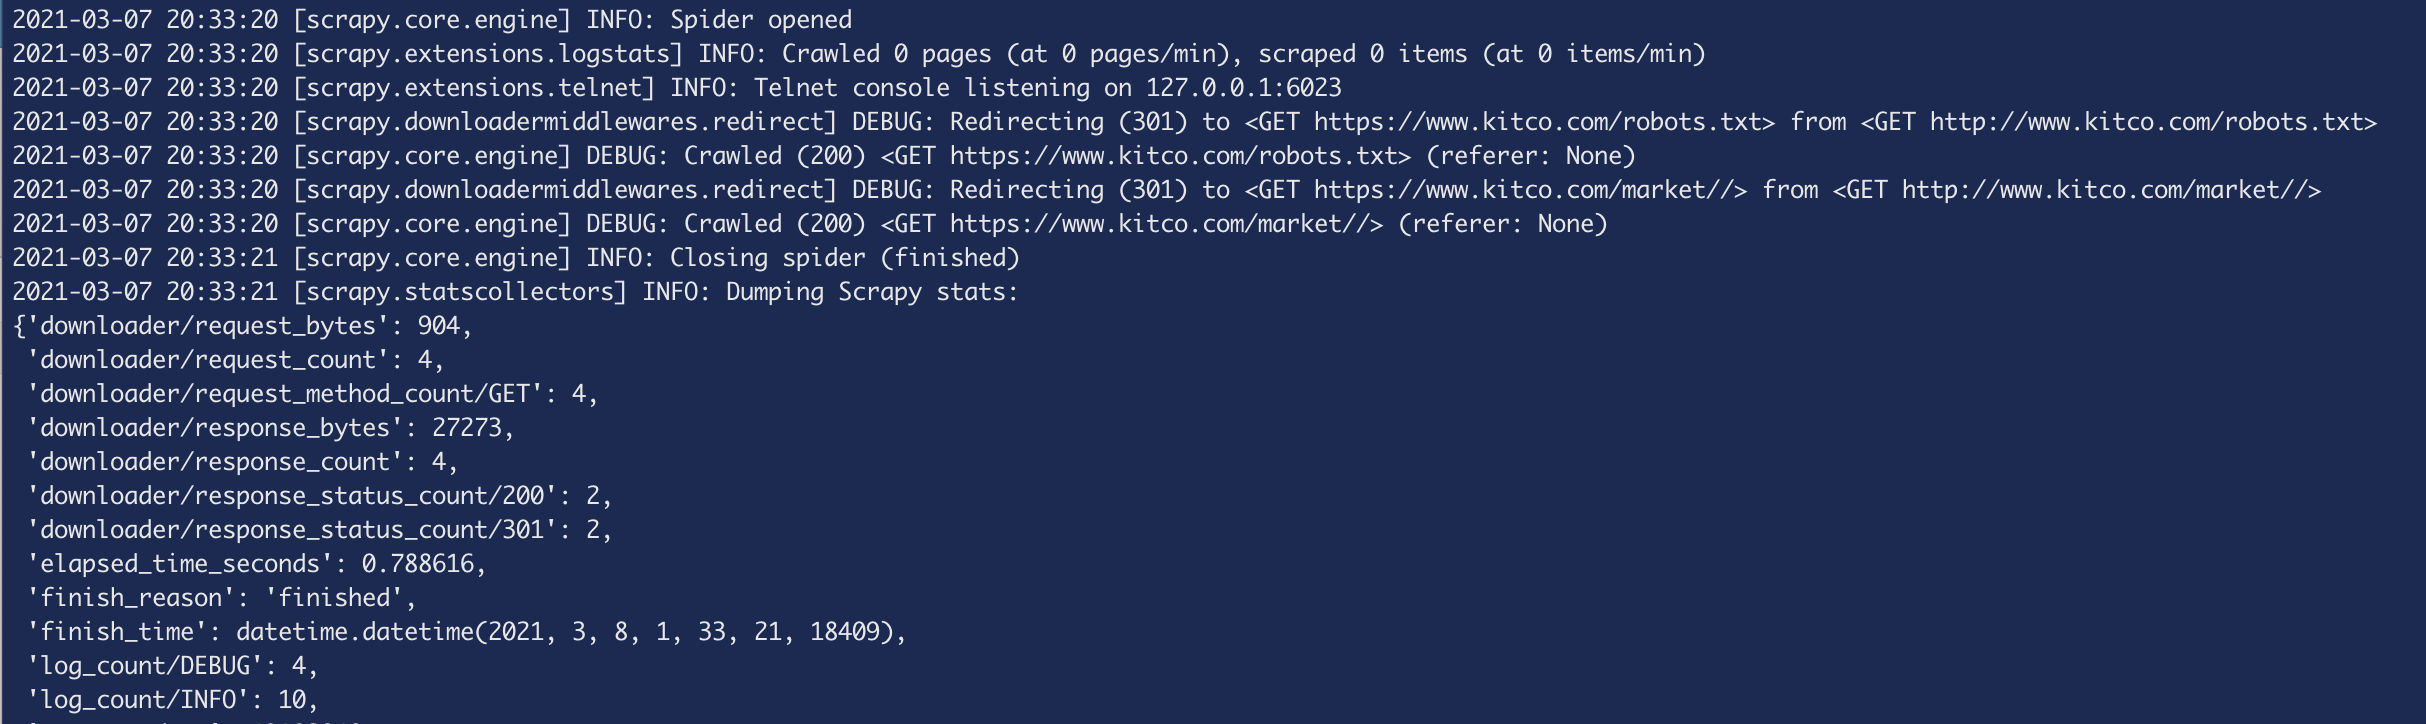 
The line that starts with ```DEBUG: Crawled (200)``` is good news, as it tells us that the spider was able to crawl the website we were after. The number in parentheses is the HTTP status code that Scrapy received in response of its request to access that page. 200 means that the request was successful and that data (the actual HTML content of that page) was sent back in response.

However, we didn’t do anything with it, because the parse method in our spider is currently empty. Let’s change that by editing the spider as follows (note the contents of the parse method):



In [ ]:
import scrapy

class MetalpricesSpider(scrapy.Spider):
    name = 'metalprices'
    
    allowed_domains = ['www.kitco.com/market']
    start_urls = ['http://www.kitco.com/market/']

    def parse(self, response):
        with open("test123.html", "wb") as file:
            file.write(response.body)

Now, if we go back to the command line and run our spider again

```scrapy crawl metalprices```

we should get similar debugging output as before, but there should also now be a file called test.html in our project’s root directory.

We can check that it contains the HTML from our target URL:

For Mac: ```cat test123.html```

For Windows: ```type test123.html```

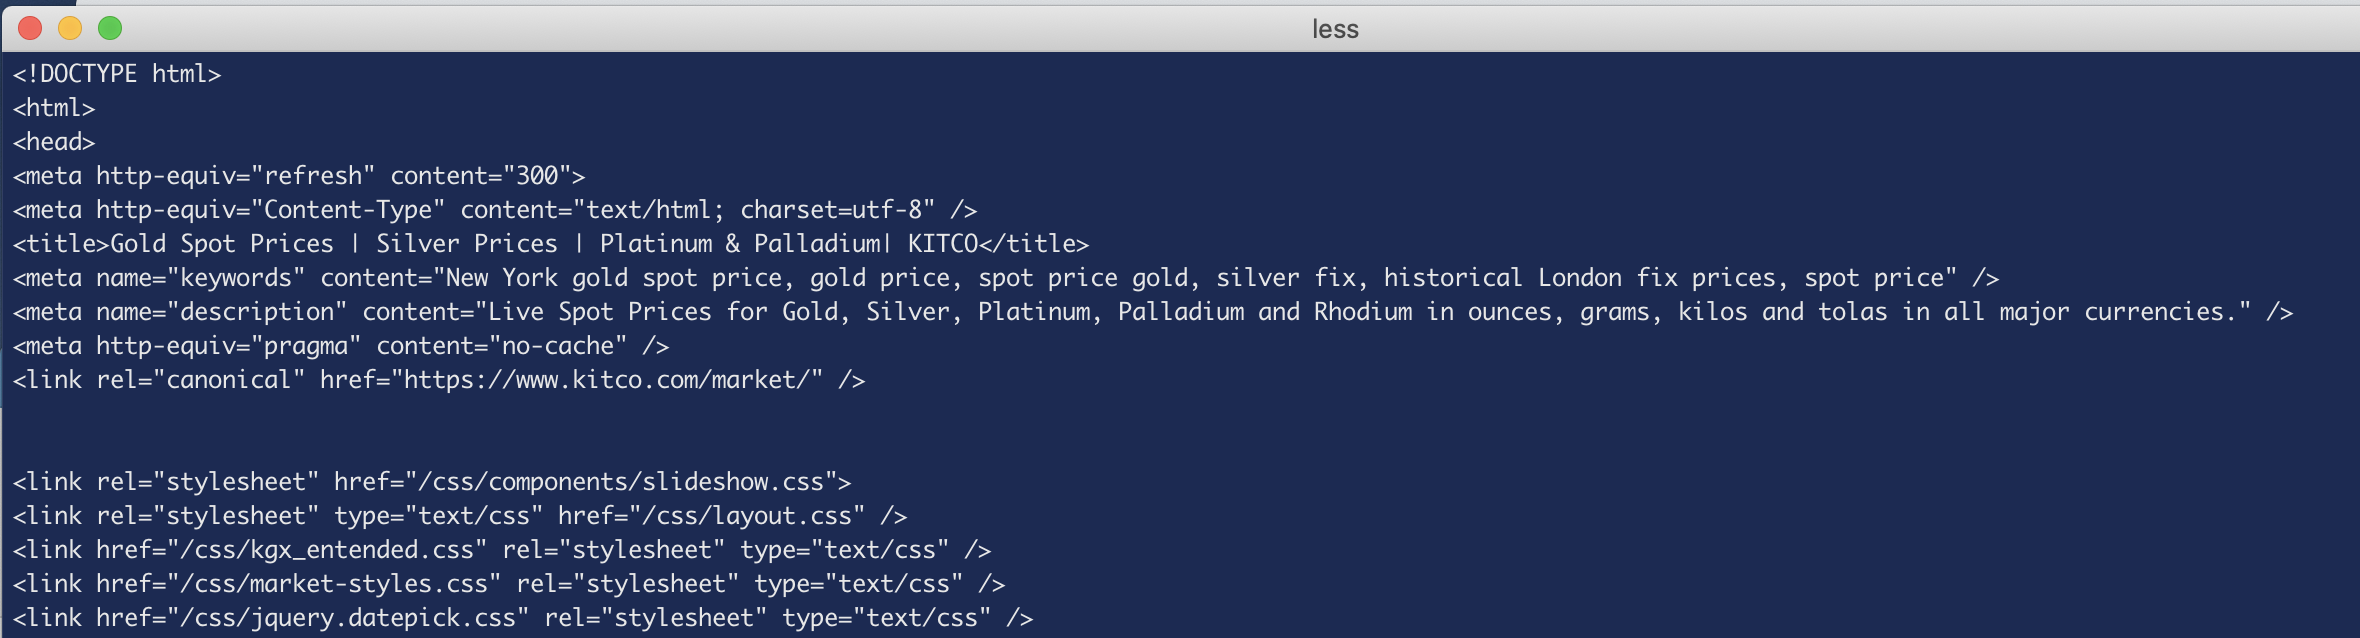

## Part 4: Defining which elements to scrape using XPath
Now that we know how to access the content of the web page with the table of metal prices, the next step is to extract the information we are interested in.

We can start by looking at the source code for our target page by using either the “View Source” or “Inspect” functions of our browser. 
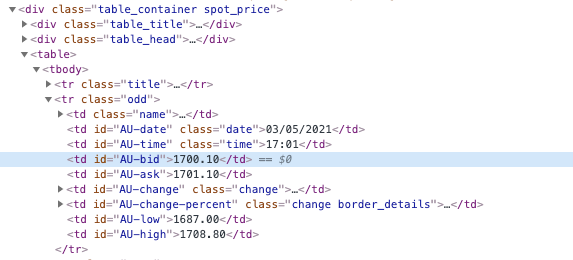

There are different strategies to target the data we are interested in. One of them is to identify that the prices are inside ```<td>``` elements of the id ```AU-bid```.

We know 'id's in HTML are unique, so seeing that each cell has its unique id will make plucking data relatively straight forward.

We can test this in the browser's JavaScript console with the following XPath query:

```$x("//td[@id='AU-bid']")[0]```
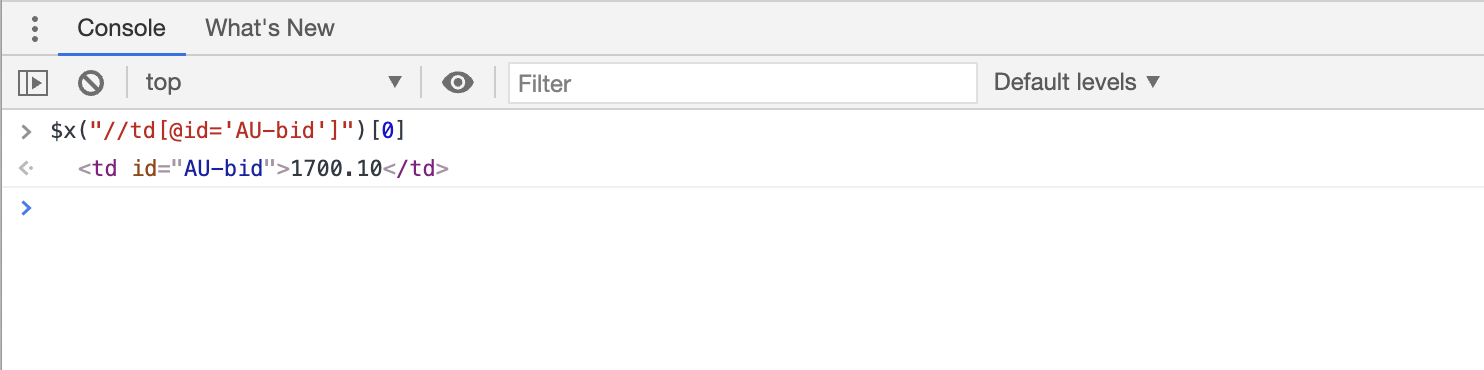

### Advanced XPath syntax
#### Predicates
Predicates are used to find a specific node or a node that contains a specific value.

Predicates are always embedded in square brackets, and are meant to provide additional filtering information to bring back nodes. You can filter on a node by using operators or functions.

Examples

|Operator	|Explanation|
|:-----|:-----|
|[1]	|Select the first node|
|[last()]	|Select the last node|
|[last()-1]	|Select the last but one node (also known as the second last node)|
|[position()<3]	|Select the first two nodes, note the first position starts at 1, not =|
|[@lang]	|Select nodes that have attribute ‘lang’|
|[@lang='en']	|Select all the nodes that have a “attribute” attribute with a value of “en”|
|[price>15.00]	|Select all nodes that have a price node with a value greater than 15.00|

Example:

```$x("//div[@class='table_container spot_price']/table/tbody/tr/td[position()=3]")```
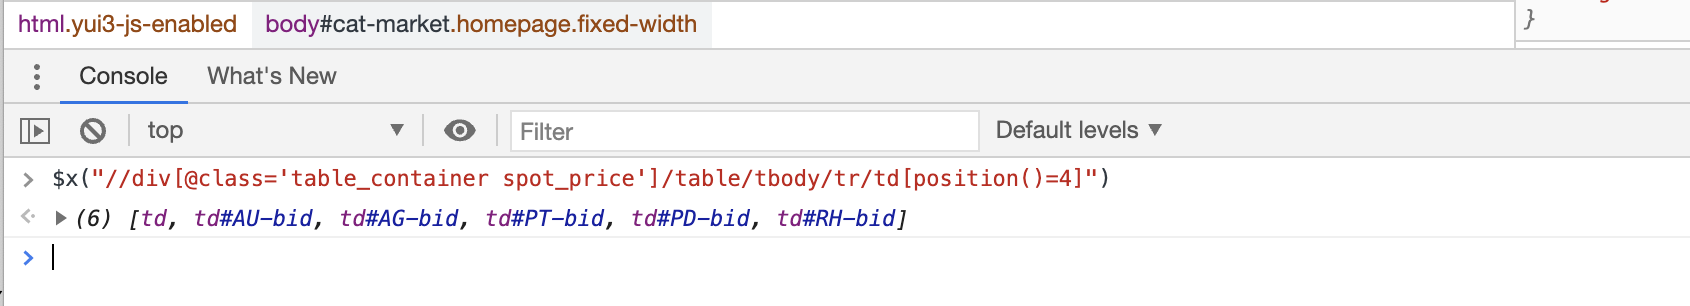

#### Wildcards
XPath wildcards can be used to select unknown XML nodes.

|Wildcard	|Description|
|---|---|
|*	|Matches any element node|
|@*	|Matches any attribute node|
|node()	|Matches any node of any kind|

### Extracting prices using the spider
Armed with the correct query, we can now update our spider accordingly. The parse methods returns the contents of the scraped page inside the response object. The response object supports a variety of methods to act on its contents:

[Here is the documentation](https://docs.scrapy.org/en/latest/topics/selectors.html) for the Scrapy 'selectors'.  This is how Scarpy 'selects' HTML components.

In [ ]:
import scrapy

class MetalpricesSpider(scrapy.Spider):
    name = 'metalprices'
    allowed_domains = ['www.kitco.com/market']
    start_urls = ['http://www.kitco.com/market/']
    
    def parse(self, response):
        for item in response.xpath("//div[@class='table_container spot_price']//td[@id='AU-bid']/text()").getall():
            print(item)

### Exporting scraped data
Scrapy conveniently includes a mechanism to collect scraped data and output it in several different useful ways. 

We will modify our parsing code to scrap a little cleaner.  We iterate over each table row and pluck out data from each cell and store them into a data format called JSON.  

**don't worry about the data format nor the detail code below if this is outside of your comfort zone.  All you need to know is that I am telling the spider to scrape the data we need and put them nicely into a data struture.**

In [ ]:
import scrapy

class MetalpricesSpider(scrapy.Spider):
    name = 'metalprices'
    allowed_domains = ['www.kitco.com/market']
    start_urls = ['http://www.kitco.com/market/']

    def parse(self, response):
        for row in response.xpath("//div[@class='table_container spot_price']//tr"):
            yield {
                'metal' : row.xpath('td[1]//text()').get(),
                'date' : row.xpath('td[2]//text()').get(),
                'time' : row.xpath('td[3]//text()').get(),
                'bid' : row.xpath('td[4]//text()').get(),
                'ask' : row.xpath('td[5]//text()').get(),
                'change' : row.xpath('td[6]//text()').get(),
                'change_per' : row.xpath('td[7]//text()').get(),
                'low' : row.xpath('td[8]//text()').get(),
                'high' : row.xpath('td[9]//text()').get()  
            }

Tell the spider to crawl output the data in JASON.  In commandline, type:

```scrapy crawl metalprices -o output.json```

To save output into a csv file, type:

```scrapy crawl metalprices -o output.csv```

## The ultimate cheat code
The mighty Pandas can actually scrap data tables with just a few line of codes! But not without its limitations...
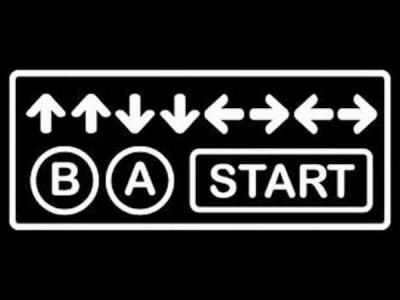

In [2]:
import pandas as pd

In [3]:
url = 'https://www.bankofcanada.ca/rates/exchange/daily-exchange-rates/'

In [4]:
df = pd.read_html(url)

In [5]:
df

[              Currency  2022‑03‑04  2022‑03‑07  2022‑03‑08  2022‑03‑09  \
 0    Australian dollar    0.938100    0.937400    0.936000    0.939000   
 1       Brazilian real    0.251100    0.251800    0.253600    0.256200   
 2     Chinese renminbi    0.201800    0.202100    0.203600    0.202900   
 3        European euro    1.392300    1.389700    1.403100    1.417300   
 4     Hong Kong dollar    0.163200    0.163400    0.164500    0.164000   
 5         Indian rupee    0.016690    0.016610    0.016710    0.016780   
 6    Indonesian rupiah    0.000089    0.000089    0.000089    0.000089   
 7         Japanese yen    0.011090    0.011070    0.011130    0.011070   
 8         Mexican peso    0.061030    0.060210    0.060230    0.061150   
 9   New Zealand dollar    0.872800    0.873400    0.877500    0.877500   
 10     Norwegian krone    0.142100    0.141300    0.143400    0.143900   
 11    Peruvian new sol    0.340900    0.341100    0.344800    0.344100   
 12       Russian ruble  